In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gzip 



from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

# nltk.download()


import re, string
import collections
import pickle
from subprocess import check_output

%matplotlib inline





In [6]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Beauty_5.json.gz')

### EDA

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013"


In [8]:
# check data type and see if any data missing

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198502 entries, 0 to 198501
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      198502 non-null  object 
 1   asin            198502 non-null  object 
 2   reviewerName    197116 non-null  object 
 3   helpful         198502 non-null  object 
 4   reviewText      198502 non-null  object 
 5   overall         198502 non-null  float64
 6   summary         198502 non-null  object 
 7   unixReviewTime  198502 non-null  int64  
 8   reviewTime      198502 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 15.1+ MB


In [9]:
# Since Reviewer name and reviewTime are not important and 
# also few review missing names we will drop these two columns

df=df.drop(['reviewerName', 'reviewTime' ], axis=1)

In [10]:

from datetime import datetime

In [11]:
# change UnixReview time to date format

time = lambda row:  datetime.fromtimestamp(row).strftime("%m-%d-%Y")
df["unixReviewTime"] = df['unixReviewTime'].apply(time)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198502 entries, 0 to 198501
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      198502 non-null  object 
 1   asin            198502 non-null  object 
 2   helpful         198502 non-null  object 
 3   reviewText      198502 non-null  object 
 4   overall         198502 non-null  float64
 5   summary         198502 non-null  object 
 6   unixReviewTime  198502 non-null  object 
dtypes: float64(1), object(6)
memory usage: 12.1+ MB


In [13]:
lenght_review=df['reviewText'].str.len()

In [14]:
lenght_review.describe()

count    198502.000000
mean        472.004307
std         511.116953
min           0.000000
25%         173.000000
50%         309.000000
75%         583.000000
max       20925.000000
Name: reviewText, dtype: float64

In [15]:
print('Number of unique products:', len(df['asin'].unique()))

Number of unique products: 12101


In [16]:
print('Number of unique products:', len(df['reviewText'].unique()))

Number of unique products: 198414


In [17]:
#lenght of review

df['revlenght'] = df['reviewText'].apply(lambda col: len(col.split(' ')))

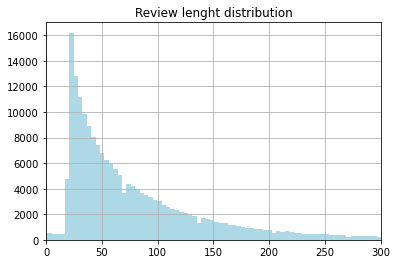

In [18]:
df['revlenght'].hist(color = 'lightblue', bins=1000);
plt.xlim(0,300)
plt.title('Review lenght distribution', fontsize =12)
plt.savefig('review_length_count_2008-2013.png')

In [19]:
# Remove reviews that has either too long or too short since I think they might not provide more insight


df = df[df['reviewText'].map(len) >= 175] 
df = df[df['reviewText'].map(len) <= 600] 
df = df.reset_index(drop=True)

In [20]:
lenght_review =df['reviewText'].str.len()

In [21]:
lenght_review.describe()

count    100317.000000
mean        337.487355
std         118.725722
min         175.000000
25%         234.000000
50%         315.000000
75%         428.000000
max         600.000000
Name: reviewText, dtype: float64

In [22]:
print("Earliest review")
df['unixReviewTime'].min()

Earliest review


'01-01-2008'

In [23]:
print('Latest review')
df['unixReviewTime'].max()

Latest review


'12-31-2013'

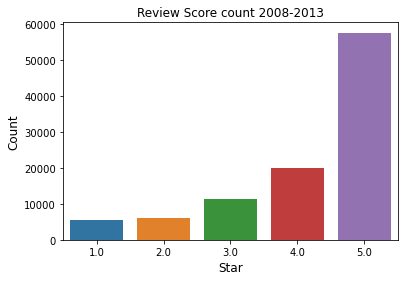

In [24]:
# plotting count of each review star

sns.countplot(x='overall', data=df);
plt.xlabel('Star',fontsize=12);
plt.ylabel('Count',fontsize=12);
plt.title('Review Score count 2008-2013',fontsize=12);
plt.savefig('review_score_count_2008-2013.png')

In [25]:
#Check porportion of the stars 

df.overall.value_counts(normalize=True)


5.0    0.573602
4.0    0.198989
3.0    0.113430
2.0    0.060279
1.0    0.053700
Name: overall, dtype: float64

In [26]:
#Set 4 and 5 star reviews to positive, and the rest to negative for later use

df['sentiment'] = np.where(df['overall'] >=4, 'positive', 'negative')

# include only the Sentiment and reviews columns

data = df[['sentiment', 'reviewText','overall', 'helpful','unixReviewTime' ]]

data.head()

,sentiment,reviewText,overall,helpful,unixReviewTime
0,positive,The texture of this concealer pallet is fantas...,4.0,"[0, 1]",09-05-2013
1,negative,"It was a little smaller than I expected, but t...",3.0,"[0, 0]",10-18-2013
2,negative,PLEASE DONT DO IT! this just rachett the palet...,1.0,"[1, 3]",08-15-2013
3,negative,"Chalky,Not Pigmented,Wears off easily,Not a Co...",2.0,"[0, 1]",09-03-2013
4,negative,Did nothing for me. Stings when I put it on. I...,2.0,"[0, 0]",07-12-2014


In [27]:
#Mostly positive reviews 
data.sentiment.value_counts(normalize=True)

positive    0.772591
negative    0.227409
Name: sentiment, dtype: float64

### NLP - Text preprocessing 

In [28]:
review = data.copy()



In [29]:
# Sample reviwe 


review['reviewText'][14]

'This is a beautiful perfume! Nice, clean scent! Perfect for day or night and never gets old. I ordered this perfume (and this was the best price offered), and it came with a lotion too! That was a nice unexpected surprise! :)'

In [30]:
# Count stopwords
stop = stopwords.words('english')

review['stopwords'] = review['reviewText'].apply(lambda x:len([x for x in x.split() if x in stop]))
review[['reviewText','stopwords']].head()

,reviewText,stopwords
0,The texture of this concealer pallet is fantas...,51
1,"It was a little smaller than I expected, but t...",31
2,PLEASE DONT DO IT! this just rachett the palet...,20
3,"Chalky,Not Pigmented,Wears off easily,Not a Co...",10
4,Did nothing for me. Stings when I put it on. I...,21


In [31]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
review['reviewText'][14]

'This is a beautiful perfume! Nice, clean scent! Perfect for day or night and never gets old. I ordered this perfume (and this was the best price offered), and it came with a lotion too! That was a nice unexpected surprise! :)'

In [33]:
#Removong numbers, capital letters, and punctuation


alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

review['reviewText'] = review.reviewText.map(alphanumeric).map(punc_lower)
review['reviewText'][14]

'this is a beautiful perfume  nice  clean scent  perfect for day or night and never gets old  i ordered this perfume  and this was the best price offered   and it came with a lotion too  that was a nice unexpected surprise    '

In [34]:
#R Remove stop words
review['reviewText'] = review['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
review['reviewText'][14]

'beautiful perfume nice clean scent perfect day night never gets old ordered perfume best price offered came lotion nice unexpected surprise'

In [35]:
# Print most common words to see if need to create custom stop words

from collections import Counter

cnt =Counter()

for text in review['reviewText'].values:
    for word in text.split():
        cnt[word] +=1
        
cnt.most_common(40)

[('hair', 58536),
 ('product', 42781),
 ('use', 39992),
 ('like', 38525),
 ('skin', 37251),
 ('great', 29631),
 ('love', 26561),
 ('really', 24473),
 ('one', 23395),
 ('good', 23332),
 ('well', 20080),
 ('would', 19169),
 ('using', 18968),
 ('used', 18595),
 ('get', 17704),
 ('color', 16059),
 ('face', 15204),
 ('much', 14655),
 ('dry', 14280),
 ('little', 14135),
 ('also', 14121),
 ('time', 13735),
 ('nice', 13238),
 ('works', 12323),
 ('products', 12265),
 ('smell', 12119),
 ('long', 11718),
 ('price', 11082),
 ('even', 10843),
 ('look', 10675),
 ('recommend', 10580),
 ('make', 10385),
 ('day', 10197),
 ('feel', 10154),
 ('better', 10123),
 ('brush', 10073),
 ('scent', 9740),
 ('soft', 9706),
 ('work', 9595),
 ('buy', 9109)]

In [36]:
stop = set(stopwords.words('english'))

#adding additional stop word which I think have no effect for my topic modeling

stopwords = ['product', 'use', 'like', 'great', 'really', 'good', 'also', 'would', 'used', 'well', 'get', 'time','color',
            'much', 'little','even', 'eventough', 'works', 'want', 'try', 'work', 'products', 'using', 'hair', 'skin',
            'got', 'lot', 'one', 'look', 'day', 'recommend', 'still', 'bit', 'way', 'since', 'buy', 'skin']

for j in stopwords:
    stop.add(j)

In [37]:

review['reviewText'] = review['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
review['reviewText'][14]

'beautiful perfume nice clean scent perfect night never gets old ordered perfume best price offered came lotion nice unexpected surprise'

In [38]:
# Remove least frequent words 

freq = pd.Series(' '.join(review['reviewText']).split()).value_counts()[-50:]
freq

shoplifting            1
acneprone              1
burnout                1
bondini                1
crunchier              1
parfumat               1
frsh                   1
reopened               1
scarguard              1
toolone                1
soolthing              1
tousles                1
goatie                 1
danskin                1
unpronounceable        1
expensively            1
endangering            1
lana                   1
liberly                1
cidar                  1
sprain                 1
airplus                1
noticeble              1
exfolitation           1
recieveing             1
subtitute              1
conduct                1
packie                 1
purposeful             1
stayput                1
dragqueenish           1
pheronomes             1
drowsiness             1
canadiannailfanatic    1
overstyled             1
cohash                 1
herethis               1
frechtwist             1
scentlight             1
craztpy                1


In [39]:
freq = list(freq.index)
review['reviewText'] = review['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
review['reviewText'][14]

'beautiful perfume nice clean scent perfect night never gets old ordered perfume best price offered came lotion nice unexpected surprise'

In [40]:
#remove special charters 

remove_special = lambda x: re.sub(r'\&\#\:', '', x)

#replace letters repeated more than 2 by 1 

# replace_letter = lambda x: re.sub(r'(\w)\1(\1+)',r'\1', x)
# replace_letter = lambda x: re.sub(r'(\w)(\1+)',r'\1', x)

review['reviewText'] = review.reviewText.map(remove_special)
review['reviewText'][14]

'beautiful perfume nice clean scent perfect night never gets old ordered perfume best price offered came lotion nice unexpected surprise'

In [41]:
#Remove white spaces 


pattern = r"[\s]+"

review['reviewText'] = review['reviewText'].str.replace(pat=pattern, repl=" ", regex=True)
review['reviewText'][14]

'beautiful perfume nice clean scent perfect night never gets old ordered perfume best price offered came lotion nice unexpected surprise'

### Lemmatization 

In [42]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [43]:
def lemmatizer (text):
    '''reads in pandas series and reviews and lemmatizas each one return series'''
    lemmas = [t.lemma_ for t in nlp(text)]
    text = ' '.join(lemmas)
    return text
    

In [44]:
lemmatizer (review["reviewText"][14])

'beautiful perfume nice clean scent perfect night never get old ordered perfume good price offer come lotion nice unexpected surprise'

In [45]:
# Run this previously since it will take a while 


# review['reviewText'] = review['reviewText'].apply(lemmatizer)  


In [47]:
# Saving if for later use 


# with open('updated_lem_review1.pickle', 'wb') as to_write:
#     pickle.dump(review, to_write)

### Sentiment analysis

In [48]:

from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [49]:
df = pd.read_pickle('updated_lem_review.pickle')

In [50]:
df.head()

,sentiment,reviewText,overall,helpful,unixReviewTime,stopwords
0,negative,oily creamy expect order try highlight contour...,1.0,"[3, 4]",01-29-2014,12
1,negative,palette decent price look different shade pale...,3.0,"[1, 1]",04-17-2014,11
2,positive,texture concealer pallet fantastic great cover...,4.0,"[0, 1]",09-05-2013,51
3,negative,tell exactly thing powder kind oil ish pasty f...,2.0,"[2, 2]",12-07-2013,12
4,negative,little small expect okay lasted long time thin...,3.0,"[0, 0]",10-18-2013,31


In [51]:
df = df.drop(['stopwords'],axis=1)

In [52]:
df.head()

,sentiment,reviewText,overall,helpful,unixReviewTime
0,negative,oily creamy expect order try highlight contour...,1.0,"[3, 4]",01-29-2014
1,negative,palette decent price look different shade pale...,3.0,"[1, 1]",04-17-2014
2,positive,texture concealer pallet fantastic great cover...,4.0,"[0, 1]",09-05-2013
3,negative,tell exactly thing powder kind oil ish pasty f...,2.0,"[2, 2]",12-07-2013
4,negative,little small expect okay lasted long time thin...,3.0,"[0, 0]",10-18-2013


In [53]:
# # spaCy - run it previously. It will take a while

# df['spacy_doc'] = list(nlp.pipe(df.reviewText))

In [54]:
# #Save the file for later use


# with open('updated_spacy.pickle', 'wb') as to_write:
#     pickle.dump(df, to_write)

In [55]:
df = pd.read_pickle('updated_spacy.pickle')
df_spacy = df

In [56]:
positive_reviews =df_spacy[df_spacy.sentiment == 'positive']
negative_reviews = df_spacy[df_spacy.sentiment== 'negative']

In [57]:

pos_adj = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='ADJ']
neg_adj = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='ADJ']

pos_noun = [token.text.lower() for doc in positive_reviews.spacy_doc for token in doc if token.pos_=='NOUN']
neg_noun = [token.text.lower() for doc in negative_reviews.spacy_doc for token in doc if token.pos_=='NOUN']

In [58]:
from collections import Counter

In [59]:
positive_adj = Counter(pos_adj).most_common(30)
positive_adj

[('great', 49287),
 ('good', 48957),
 ('dry', 33527),
 ('little', 26163),
 ('long', 22264),
 ('soft', 20639),
 ('nice', 20381),
 ('clean', 14496),
 ('smooth', 13291),
 ('natural', 12639),
 ('many', 12267),
 ('thick', 12194),
 ('small', 12044),
 ('perfect', 11266),
 ('easy', 10363),
 ('first', 10181),
 ('fine', 9498),
 ('different', 9287),
 ('light', 9034),
 ('dark', 8682),
 ('amazing', 8406),
 ('sensitive', 8353),
 ('happy', 8194),
 ('big', 7331),
 ('strong', 7205),
 ('old', 7073),
 ('enough', 7052),
 ('new', 6858),
 ('expensive', 6688),
 ('top', 6587)]

In [60]:

negative_adj = Counter(neg_adj).most_common(30)
negative_adj

[('good', 12695),
 ('dry', 9543),
 ('little', 6452),
 ('great', 6101),
 ('bad', 5067),
 ('long', 4862),
 ('nice', 4300),
 ('thick', 3933),
 ('small', 3395),
 ('different', 3283),
 ('fine', 3184),
 ('first', 3135),
 ('natural', 3033),
 ('soft', 3020),
 ('many', 2949),
 ('cheap', 2916),
 ('dark', 2799),
 ('clean', 2793),
 ('sensitive', 2740),
 ('strong', 2511),
 ('old', 2355),
 ('big', 2279),
 ('light', 2255),
 ('enough', 2242),
 ('smooth', 2136),
 ('high', 2078),
 ('thin', 2031),
 ('hard', 2009),
 ('worth', 1888),
 ('several', 1826)]

In [61]:
positive_adj = dict(positive_adj)
positive_adj

{'great': 49287,
 'good': 48957,
 'dry': 33527,
 'little': 26163,
 'long': 22264,
 'soft': 20639,
 'nice': 20381,
 'clean': 14496,
 'smooth': 13291,
 'natural': 12639,
 'many': 12267,
 'thick': 12194,
 'small': 12044,
 'perfect': 11266,
 'easy': 10363,
 'first': 10181,
 'fine': 9498,
 'different': 9287,
 'light': 9034,
 'dark': 8682,
 'amazing': 8406,
 'sensitive': 8353,
 'happy': 8194,
 'big': 7331,
 'strong': 7205,
 'old': 7073,
 'enough': 7052,
 'new': 6858,
 'expensive': 6688,
 'top': 6587}

In [62]:
negative_adj = dict(negative_adj)

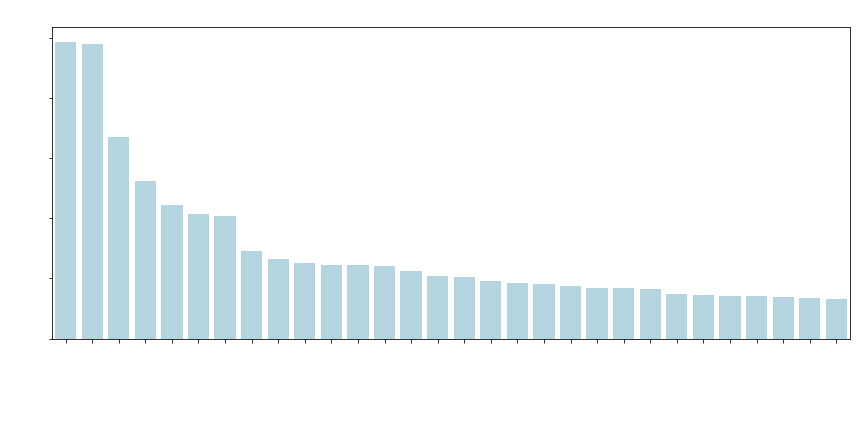

In [70]:
# Top 30 most positive adj



plt.figure(figsize=(12,6))
sns.barplot(list(positive_adj.keys()), list(positive_adj.values()), color="LightBlue")
plt.xticks(rotation=90,fontsize=14, color='white');
plt.title('Sentiment Analysis - Top 30 Words in Positive Reviews',fontsize=20, color='white');
plt.yticks(fontsize=12, color='white');

plt.tight_layout();
plt.savefig('word__freq_pos_rev.png')

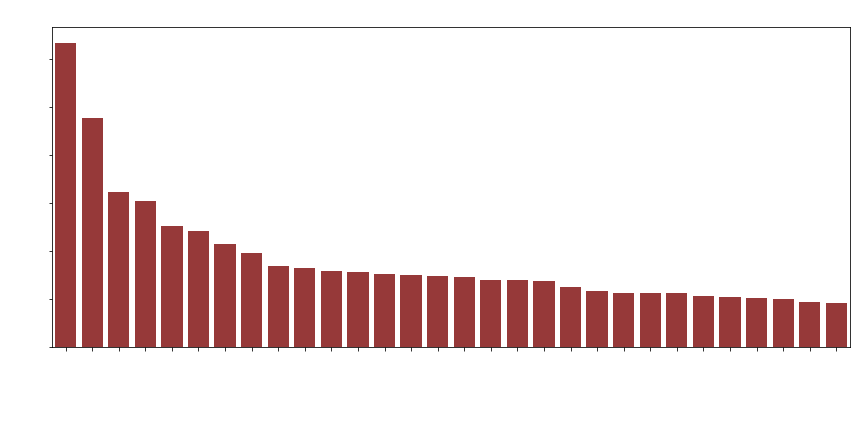

In [76]:
# Top 30 most negative polar

plt.figure(figsize=(12,6))
sns.barplot(list(negative_adj.keys()), list(negative_adj.values()), color='brown')
plt.xticks(rotation=90,fontsize=14, color='white');
plt.title('Sentiment Analysis - Top 30 Words in Negative Reviews',fontsize=20, color='white');
plt.yticks(fontsize=12, color='white');
plt.tight_layout();
plt.savefig('word__freq_neg_rev.png')


In [79]:
Counter(pos_noun).most_common(20)

[('hair', 119234),
 ('skin', 82590),
 ('love', 39725),
 ('color', 39664),
 ('work', 38512),
 ('time', 35246),
 ('face', 28658),
 ('day', 27509),
 ('price', 22689),
 ('oil', 22295),
 ('nail', 21329),
 ('shampoo', 21099),
 ('brush', 18616),
 ('smell', 17504),
 ('eye', 17024),
 ('conditioner', 16139),
 ('cream', 15861),
 ('way', 15225),
 ('bottle', 14879),
 ('bit', 13768)]

In [80]:
Counter(neg_noun).most_common(20)

[('hair', 37052),
 ('skin', 19681),
 ('work', 11232),
 ('color', 10148),
 ('time', 10124),
 ('face', 7522),
 ('day', 6779),
 ('shampoo', 6069),
 ('smell', 5863),
 ('oil', 5703),
 ('eye', 5244),
 ('brush', 4898),
 ('conditioner', 4861),
 ('price', 4721),
 ('cream', 4706),
 ('thing', 4434),
 ('bottle', 4424),
 ('way', 4397),
 ('nail', 4348),
 ('bit', 3842)]

### Vader Sentiment Analysis

In [81]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [82]:
df = pd.read_pickle('updated_lem_review.pickle')

In [83]:
analyzer = SentimentIntensityAnalyzer()
scores = []

for doc in df['reviewText']:
    vs = analyzer.polarity_scores(doc)
    scores.append(vs)

In [84]:
scores[:5]

[{'neg': 0.183, 'neu': 0.671, 'pos': 0.146, 'compound': -0.1531},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.052, 'neu': 0.575, 'pos': 0.373, 'compound': 0.9538},
 {'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'compound': 0.5267},
 {'neg': 0.045, 'neu': 0.701, 'pos': 0.254, 'compound': 0.7631}]

In [85]:
negative_scores =[score['neg'] for score in scores]
positive_scores =[score['pos']  for score in scores]
neutral_scores = [score['neu'] for score in scores]
compound_scores =[score['compound'] for score in scores]

In [86]:
df['vader_neg'] = negative_scores
df['vader_pos'] = positive_scores
df['vader_neut'] = neutral_scores
df['compound'] = compound_scores


In [96]:
df['sentiment_class'] = np.where(df['overall'] >=4, '1', '0')
df['vader_class'] = np.where(df['compound'] >=0, '1', '0')

In [97]:
df.head()

,sentiment,reviewText,overall,helpful,unixReviewTime,stopwords,vader_neg,vader_pos,vader_neut,compound,sentiment_class,vader_class
0,negative,oily creamy expect order try highlight contour...,1.0,"[3, 4]",01-29-2014,12,0.183,0.146,0.671,-0.1531,0,0
1,negative,palette decent price look different shade pale...,3.0,"[1, 1]",04-17-2014,11,0.000,0.000,1.000,0.0000,0,1
2,positive,texture concealer pallet fantastic great cover...,4.0,"[0, 1]",09-05-2013,51,0.052,0.373,0.575,0.9538,1,1
3,negative,tell exactly thing powder kind oil ish pasty f...,2.0,"[2, 2]",12-07-2013,12,0.000,0.175,0.825,0.5267,0,1
4,negative,little small expect okay lasted long time thin...,3.0,"[0, 0]",10-18-2013,31,0.045,0.254,0.701,0.7631,0,1


In [98]:
df['vader_neg_roll'] = df['vader_neg'].rolling(5, center=True).mean()
df['vader_pos_roll'] = df['vader_pos'].rolling(5, center=True).mean()
df['vader_neut_roll'] = df['vader_neut'].rolling(5, center=True).mean()
df['vader_compound_roll'] = df['compound'].rolling(5, center=True).mean()
df.shape

(198108, 16)

In [99]:
df.head()

,sentiment,reviewText,overall,helpful,unixReviewTime,stopwords,vader_neg,vader_pos,vader_neut,compound,sentiment_class,vader_class,vader_neg_roll,vader_pos_roll,vader_neut_roll,vader_compound_roll
0,negative,oily creamy expect order try highlight contour...,1.0,"[3, 4]",01-29-2014,12,0.183,0.146,0.671,-0.1531,0,0,NaN,NaN,NaN,NaN
1,negative,palette decent price look different shade pale...,3.0,"[1, 1]",04-17-2014,11,0.000,0.000,1.000,0.0000,0,1,NaN,NaN,NaN,NaN
2,positive,texture concealer pallet fantastic great cover...,4.0,"[0, 1]",09-05-2013,51,0.052,0.373,0.575,0.9538,1,1,0.0560,0.1896,0.7544,0.41810
3,negative,tell exactly thing powder kind oil ish pasty f...,2.0,"[2, 2]",12-07-2013,12,0.000,0.175,0.825,0.5267,0,1,0.0194,0.2484,0.7322,0.64528
4,negative,little small expect okay lasted long time thin...,3.0,"[0, 0]",10-18-2013,31,0.045,0.254,0.701,0.7631,0,1,0.0194,0.2896,0.6910,0.77266


In [100]:
type(df['overall'][0])

numpy.float64

In [101]:
# Savign the for later use


# df.to_csv('sentiment_vader1.csv') 

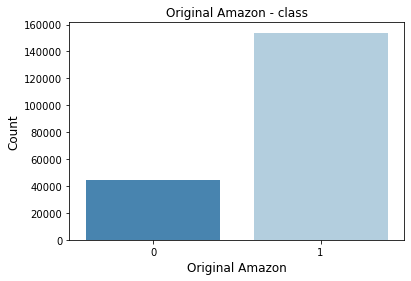

In [102]:
# plot original review class 

sns.countplot(x='sentiment_class', data=df, palette ='Blues_r');
plt.xlabel('Original Amazon', fontsize = 12);
plt.ylabel('Count', fontsize = 12);
plt.title("Original Amazon - class", fontsize =12);
plt.savefig('review_score_amazon_original 2003-2008')


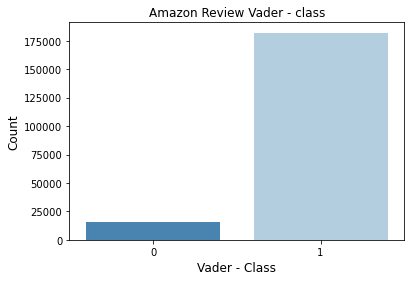

In [103]:
# plot original review class 

sns.countplot(x='vader_class', data=df, palette ='Blues_r');
plt.xlabel('Vader - Class', fontsize = 12);
plt.ylabel('Count', fontsize = 12);
plt.title("Amazon Review Vader - class", fontsize =12);
plt.savefig('review_score_vader_score 2003-2008')

In [104]:
# Plot review ti9me by stars

# Divide the data by score and group for each month
grp_s1=df[df['overall']==1.0]
grp_s2=df[df['overall']==2.0]
grp_s3=df[df['overall']==3.0]
grp_s4=df[df['overall']==4.0]
grp_s5=df[df['overall']==5.0]

grp_date_1=grp_s1.groupby(by=['unixReviewTime']).count();
grp_date_2=grp_s2.groupby(by=['unixReviewTime']).count();
grp_date_3=grp_s3.groupby(by=['unixReviewTime']).count();
grp_date_4=grp_s4.groupby(by=['unixReviewTime']).count();
grp_date_5=grp_s5.groupby(by=['unixReviewTime']).count();

grp_date_1.reset_index(inplace=True); #to make it to column
grp_date_2.reset_index(inplace=True);
grp_date_3.reset_index(inplace=True);
grp_date_4.reset_index(inplace=True);
grp_date_5.reset_index(inplace=True);

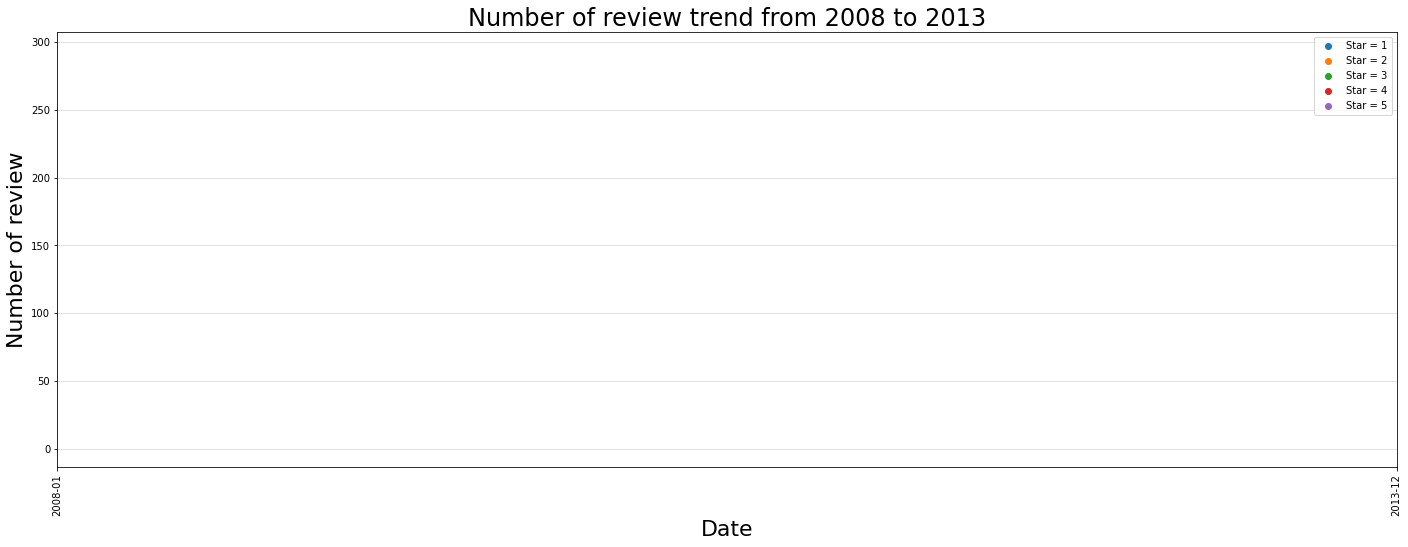

In [105]:
# review count by score for each month from 2000 to 2012
plt.figure(figsize=(24,8))

plt.plot_date(x=grp_date_1['unixReviewTime'],y=grp_date_1['overall'],label='Star = 1');
plt.plot_date(x=grp_date_2['unixReviewTime'],y=grp_date_2['overall'],label='Star = 2');
plt.plot_date(x=grp_date_3['unixReviewTime'],y=grp_date_3['overall'],label='Star = 3');
plt.plot_date(x=grp_date_4['unixReviewTime'],y=grp_date_4['overall'],label='Star = 4');
plt.plot_date(x=grp_date_5['unixReviewTime'],y=grp_date_5['overall'],label='Star = 5');
plt.xticks(rotation=90);
plt.legend()
plt.grid(linewidth=0.5,alpha=0.75)
plt.xlim('2008-01','2013-12');
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Number of review trend from 2008 to 2013',fontsize=24);
plt.savefig('date_rev_trend.png')
# grp_date